In [2]:
import numpy as np
import jax
import jax.numpy as jnp
from matplotlib import pyplot as pl

from interferometer import Interferometer
import jimgw
import lal

import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'

import optax
import corner                            
#jax.config.update('jax_platform_name', 'cpu')

import distrax
import haiku as hk      #neural network library for JAX 
from typing import Any, Iterator, Mapping, Optional, Sequence, Tuple
Array = jnp.ndarray
PRNGKey = Array
OptState = Any

from curses import KEY_REPLACE
import lalsimulation as lalsim 
from jimgw.PE.detector_preset import * 
#from jimgw.PE.detector_projection import make_detector_response
from detector_projection import make_detector_response 
#from detector_projection import make_antenna_response

from jax.config import config
config.update("jax_enable_x64", True)

%matplotlib inline

In [3]:
f_min = 0. #minimum frequency cut-off
T = 1.  #data segment duration (8 seconds)
Fs = 100. #samplingfrequency  (Hz)
#t_start = 1126259446. #strain data segment start time 
t_start=0.
# since signals are generated in frequency domain this time is only used for calculating time dealys and hence is set to t_coalsecence

#initialise the detectors
H1_d = Interferometer('H1','O3',f_min,T,Fs,t_start,20011997)
L1_d = Interferometer('L1','O3',f_min,T,Fs,t_start,27071994)

In [4]:
def simulate_fd_sine_gaussian_waveform(A, t0, f0, tau, times, fmin, df):   #without phase for now
    
    t = times
    
    hpt = A*jnp.exp(-(t-t0)**2/tau**2)*jnp.cos(2*jnp.pi*f0*t) #time domain plus polarisation
    hct = A*jnp.exp(-(t-t0)**2/tau**2)*jnp.sin(2*jnp.pi*f0*t) #time domain cross polarisation

    hp = jnp.fft.rfft(hpt) #frequency domain plus polarisation
    hc = jnp.fft.rfft(hct) #frequency domain cross polarisation

    return hp, hc

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


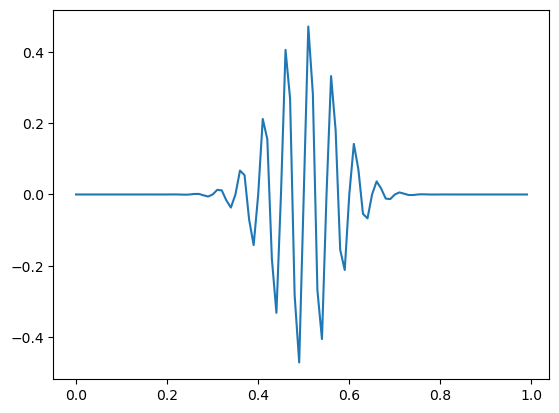

In [5]:
f0 = 4.
true_params = dict(
        A=0.5,
        t0=0.5,
        f0=20.,
        tau=1/10,
        ra=jnp.atleast_1d(0.5),
        dec=jnp.atleast_1d(0.5),
        psi=jnp.atleast_1d(0.5))

#simulate signal 
hp, hc = simulate_fd_sine_gaussian_waveform(true_params['A'], true_params['t0'], true_params['f0'], true_params['tau'], H1_d.times, f_min,H1_d.df)
hct = jnp.fft.irfft(hc)
pl.plot(H1_d.times,hct)

/home/dominika/.conda/envs/vigw/lib/python3.10/site-packages/jax/_src/array.py:341: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(self._value, dtype=dtype)


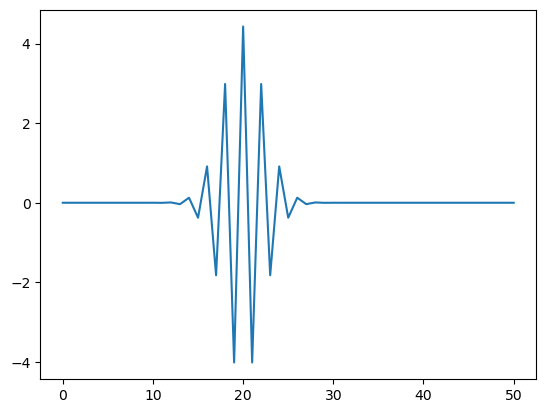

In [6]:
pl.plot(H1_d.freqs,hp)

In [7]:
H1 = get_H1()
H1_response = make_detector_response(H1[0], H1[1])   #detector_response(f, hp, hc, ra, dec, gmst, psi), strain in freq domain
L1 = get_L1()
L1_response = make_detector_response(L1[0], L1[1])   

gps = lal.LIGOTimeGPS(true_params['t0'])
gmst_rad = lal.GreenwichMeanSiderealTime(gps)

L1_signal = L1_response(H1_d.freqs, hp, hc, true_params['ra'], true_params['dec'], gmst_rad, true_params['psi'])   
H1_signal = H1_response(H1_d.freqs, hp, hc, true_params['ra'], true_params['dec'], gmst_rad, true_params['psi'])

#H1_noise = 0
#L1_noise = 0

#H1_noise = noise_fd_dict['H1'][freqs>fmin]
#H1_data = H1_noise + H1_signal

#L1_noise = noise_fd_dict['L1'][freqs>fmin]
#L1_data = L1_noise + L1_signal

response = {'H1': H1_response, 'L1': L1_response}

In [8]:
#from interferometer import Interferometer
from interferometer import Network
H1_d.signal=H1_signal
L1_d.signal=L1_signal
H1_d.psd=1.
L1_d.psd=1.
print(H1_d.get_signal_snr(),L1_d.get_signal_snr())
network = Network([H1_d,L1_d])
network.snr()

13.939145804194915 17.257479471123187


22.183786499307168

In [9]:
def project_to_detector(detector, hp, hc, ra, dec, gmst_rad, psi):                   #unfix the frequency array?
    """Compute the response of the detector to incoming strain """
    return response[detector](jnp.atleast_2d(H1_d.freqs), hp, hc, ra, dec, gmst_rad, psi)

In [10]:
test_params = dict(
        A = jnp.array([0.5,2.]),
        ra=jnp.array([0.5,1.]),
        dec=jnp.array([0.5,0.8]),
        psi=jnp.array([0.5,1.5]))

In [11]:
hp, hc = simulate_fd_sine_gaussian_waveform(jnp.atleast_2d(test_params['A']).T, true_params['t0'], true_params['f0'], true_params['tau'], jnp.atleast_2d(H1_d.times), f_min,H1_d.df)
        
#jnp.array([ self.simulate_response(hp, hc, params['ra'][i], params['dec'][i], params['psi'][i]) for i in range(len(params['ra']))])
response['H1'](jnp.atleast_2d(H1_d.freqs), hp, hc, test_params['ra'], test_params['dec'], gmst_rad, test_params['psi'])

Array([[ 1.40988801e-12+0.00000000e+00j,  1.38251242e-12+3.92711905e-13j,
         1.28349292e-12+7.33723133e-13j,  1.07330048e-12+2.57561330e-12j,
         6.42038053e-12-3.52292639e-11j, -1.98105968e-10+7.68127249e-10j,
         4.86662132e-09-1.29690937e-08j, -8.90722152e-08+1.77968397e-07j,
         1.26474275e-06-1.97672062e-06j, -1.41824023e-05+1.77433094e-05j,
         1.26860181e-04-1.28376875e-04j, -9.10718892e-04+7.45856065e-04j,
         5.26807383e-03-3.45952718e-03j, -2.46202865e-02+1.26905768e-02j,
         9.31347769e-02-3.62089469e-02j, -2.85537661e-01+7.76925789e-02j,
         7.10102546e-01-1.14978491e-01j, -1.43323125e+00+7.94666269e-02j,
         2.34833979e+00+1.16918936e-01j, -3.12361826e+00-4.87700562e-01j,
         3.37210738e+00+8.97120517e-01j, -2.95302247e+00-1.12893807e+00j,
         2.09598928e+00+1.06545705e+00j, -1.20427106e+00-7.81151705e-01j,
         5.59093205e-01+4.52637236e-01j, -2.09183356e-01-2.09308902e-01j,
         6.28297421e-02+7.77019820e-02

In [12]:
# likelihood function

class LogL(object):
    
    def __init__(self, true_gw_params):
        
        self.true_gw_params = true_gw_params
        self.detectors = {'H1': H1, 'L1': L1}
        
        gps_time = true_gw_params['t0']     #time of coalescence
        gps = lal.LIGOTimeGPS(gps_time)
        self.gmst_rad = lal.GreenwichMeanSiderealTime(gps)

        self.A = true_gw_params['A']
        self.t0 = true_gw_params['t0']
        self.f0 = true_gw_params['f0']
        self.tau = true_gw_params['tau']
        self.ra=jnp.atleast_1d(true_gw_params['ra'])
        self.dec = jnp.atleast_1d(true_gw_params['dec'])
        self.psi= jnp.atleast_1d(true_gw_params['psi'])

        self.f_min = 0.
        self.times = H1_d.times
        self.df = H1_d.df
        self.times2d = jnp.atleast_2d(H1_d.times)
        
        self.hp, self.hc = simulate_fd_sine_gaussian_waveform(self.A, self.t0, self.f0, self.tau, H1_d.times, self.f_min, H1_d.df)
        self.data = self.simulate_response(self.hp, self.hc, self.ra, self.dec, self.psi)
        

    #def simulate_response_matrix(self, hp, hc, ra, dec, psi):
        # r = {d: project_to_detector(d, hp, hc, ra, dec, self.gmst_rad, psi) for d in self.detectors.keys()}
        #print('before loop')
        #r = {d: jnp.array([project_to_detector(d, hp[i], hc[i], ra[i], dec[i], self.gmst_rad, psi[i]) for i in range(len(ra))]) for d in self.detectors.keys()}
        #print('after loop')
        #return r
    
    def simulate_response(self, hp, hc, ra, dec, psi):
        r = {d: project_to_detector(d, hp, hc, ra, dec, self.gmst_rad, psi) for d in self.detectors.keys()}
        return r
    
    def __call__(self, params):
        hp, hc = simulate_fd_sine_gaussian_waveform(jnp.atleast_2d(params['A']).T, self.t0, self.f0, self.tau, self.times2d, self.f_min, self.df)
        #hp, hc = simulate_fd_sine_gaussian_waveform(self.A, self.t0, self.f0, self.tau, self.times2d, self.f_min, self.df)
       
        r = self.simulate_response(hp, hc, params['ra'], params['dec'], params['psi'])

        residuals = jnp.array([r[ifo] - self.data[ifo] for ifo in self.detectors.keys()])
        
        return -jnp.real(jnp.sum(residuals*jnp.conj(residuals),axis=(0,2)))/2

    @property
    def params(self):
        params = ['A','ra','dec','psi']
        #params = ['ra','dec','psi']
        return params

    #@jax.jit
    def array_to_phys(self, x: Array) -> dict:
        
        p = dict()
        #p['A'] = x[:,0]
        #p['ra'] = (x[:,1]+1)*jnp.pi  #[0,2pi]
        #p['dec'] = (x[:,2])*jnp.pi/2  #[-pi/2,pi/2]
        #p['psi'] = (x[:,3]+1)*jnp.pi/2 #[0,pi]
        p['A'] = x[:,0]
        p['ra'] = x[:,1]  #[0,2pi]
        p['dec'] = x[:,2] #[-pi/2,pi/2]
        p['psi'] = x[:,3] #[0,pi]

        return p

In [13]:
#Neural network setup

from vi_routines import make_flow_model

@hk.without_apply_rng
@hk.transform
def sample_and_log_prob(prng_key: PRNGKey, n: int) -> Tuple[Any, Array]:

    model = make_flow_model(                          #this is the flow distribution (a distrax object)
        event_shape=(n_params,),
        num_layers=flow_num_layers,
        hidden_sizes=[hidden_size] * mlp_num_layers,
        num_bins=num_bins
    )

    return model.sample_and_log_prob(seed=prng_key, sample_shape=(n,))
     # returns x (sample from the flow q), and model.log_prob(x) (array of log(q) of th sampled points)


def log_likelihood(x: Array) -> Array:      #transform to parameter space before c
    p = log_l.array_to_phys(x)
    return log_l(p) 

def loss_fn(params: hk.Params, prng_key: PRNGKey, n: int) -> Array:       #computes reverse KL-divergence for the sample x_flow between the flow and gw loglikelihood.

    x_flow, log_q = sample_and_log_prob.apply(params, prng_key, n)           #gets sample from the flow and computes log_q for the sampled points.
    log_p = log_likelihood(x_flow)
                                           #gets gw loglikelihood for the sampled points (after transforming them into physical space..)
    loss = jnp.mean(log_q - log_p)
    return loss

@jax.jit
def update(
    params: hk.Params,
    prng_key: PRNGKey,
    opt_state: OptState,
) -> Tuple[hk.Params, OptState]:
    """Single SGD update step."""
    grads = jax.grad(loss_fn)(params, prng_key, Nsamps)
    updates, new_opt_state = optimiser.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state

In [48]:
n_params = 4
flow_num_layers = 4
hidden_size = 16
mlp_num_layers = 2
num_bins = 4


# perform variational inference
epochs = 2000
loss = dict(train=[], val=[])
Nsamps = 1000


In [49]:

learning_rate = 0.001
optimiser = optax.adam(learning_rate)              #stochastic gradient descent 

prng_seq = hk.PRNGSequence(42)
key = next(prng_seq)
params = sample_and_log_prob.init(key, prng_key=key, n=Nsamps)
opt_state = optimiser.init(params)

from tqdm import tqdm, trange
   
ldict = dict(loss = [], T=1)
L=[]

log_l = LogL(true_params)         


In [50]:
log_l(true_params)

Array([-0.], dtype=float64)

In [51]:
truths=[0.5,0.5,0.5,0.5]

  0%|          | 0/2000 [00:00<?, ?it/s, loss=51.08, T=1]

Epoch 0, loss 51.07767897081436


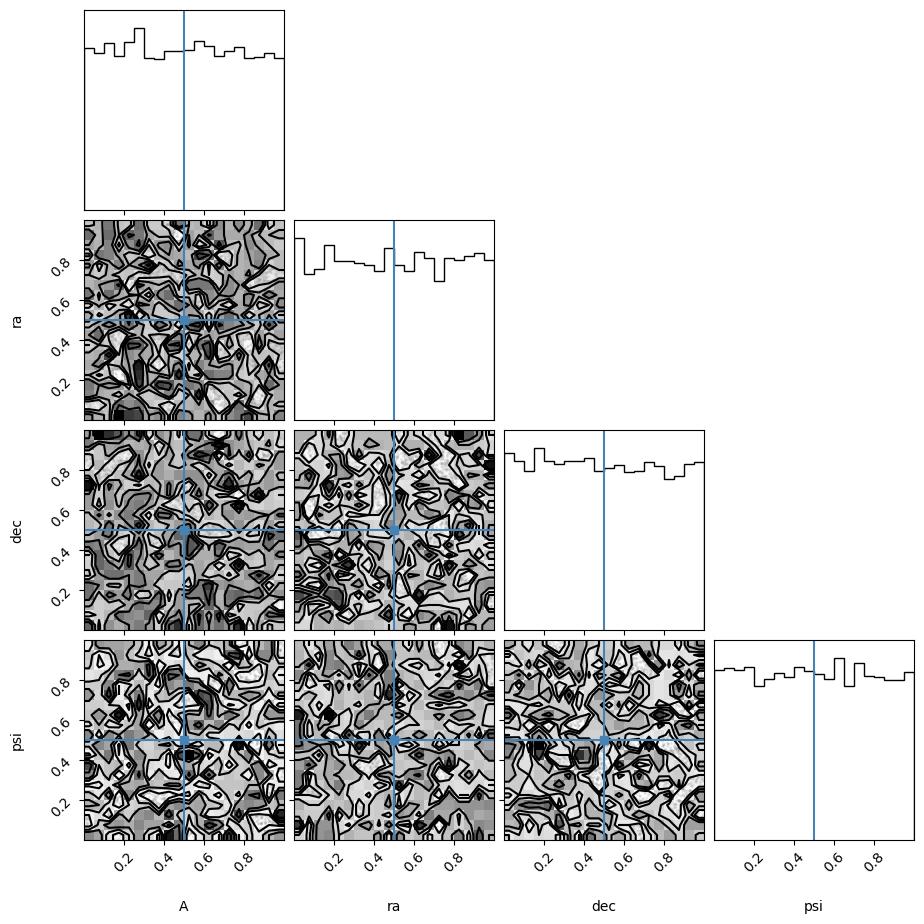

 50%|█████     | 1000/2000 [05:58<05:52,  2.84it/s, loss=5.73, T=1]

Epoch 1000, loss 5.728961301164293


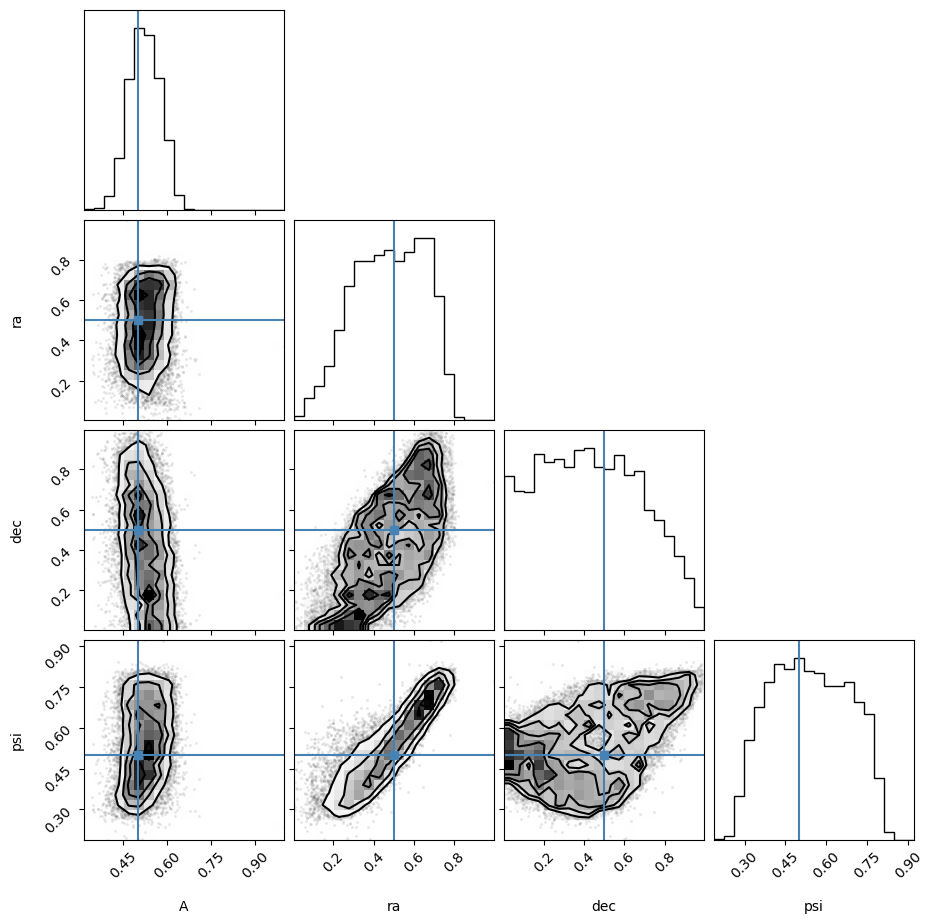

100%|██████████| 2000/2000 [11:36<00:00,  2.87it/s, loss=5.64, T=1]


Done!


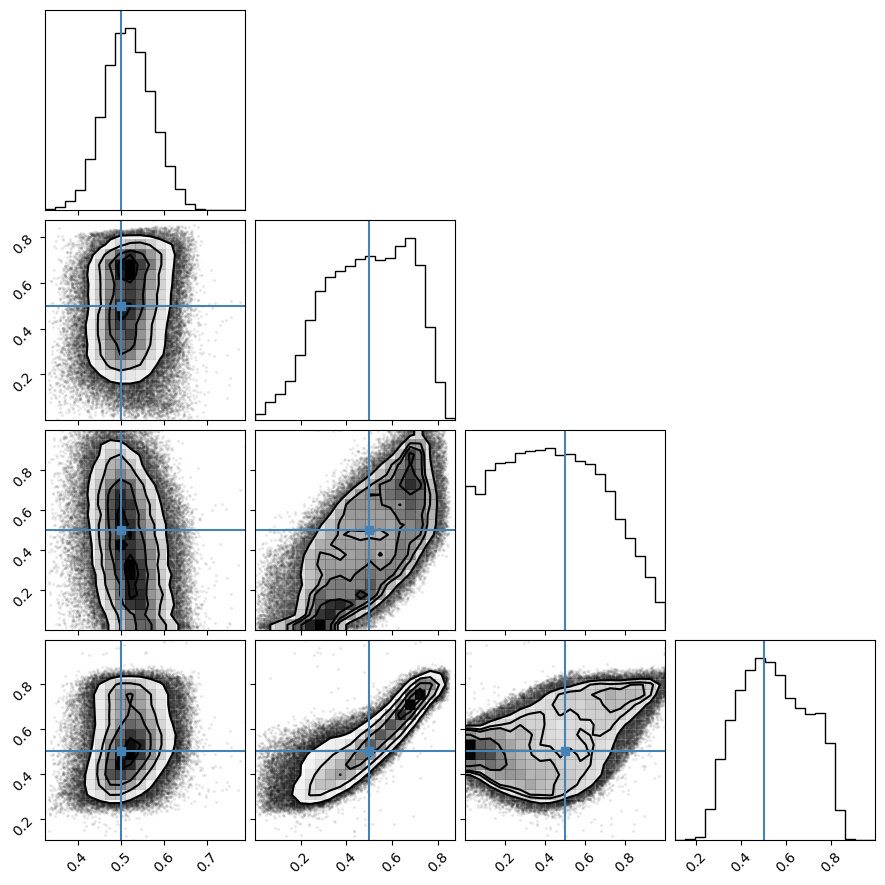

In [52]:

with trange(epochs) as tepochs:
    for epoch in tepochs:
  
        #update NN params (stochastic gradient descent with Adam optimiser)
        prng_key = next(prng_seq)
        loss = loss_fn(params,  prng_key, Nsamps)
        ldict['loss'] = f'{loss:.2f}'
        L.append(loss)
        tepochs.set_postfix(ldict, refresh=True)
        params, opt_state = update(params, prng_key, opt_state)        #take a step in direction of stepest descent (negative gradient)

        #print results every 50 iterations
        if epoch%1000 == 0:
            print(f'Epoch {epoch}, loss {loss}')
            x_gen, log_prob_gen = sample_and_log_prob.apply(params, next(prng_seq), 10*Nsamps)
            x_gen = np.array(x_gen, copy=False)
            p_gen = np.vstack(list(log_l.array_to_phys(x_gen).values()))
            fig = corner.corner(p_gen.T, labels=log_l.params, truths = truths)
            pl.show()

print("Done!")

x_gen, log_prob_gen = sample_and_log_prob.apply(params, next(prng_seq), 100*Nsamps)

x_gen = np.array(x_gen, copy=False)
p_gen = np.vstack(list(log_l.array_to_phys(x_gen).values()))
fig = corner.corner(p_gen.T, truths = truths)

pl.show()

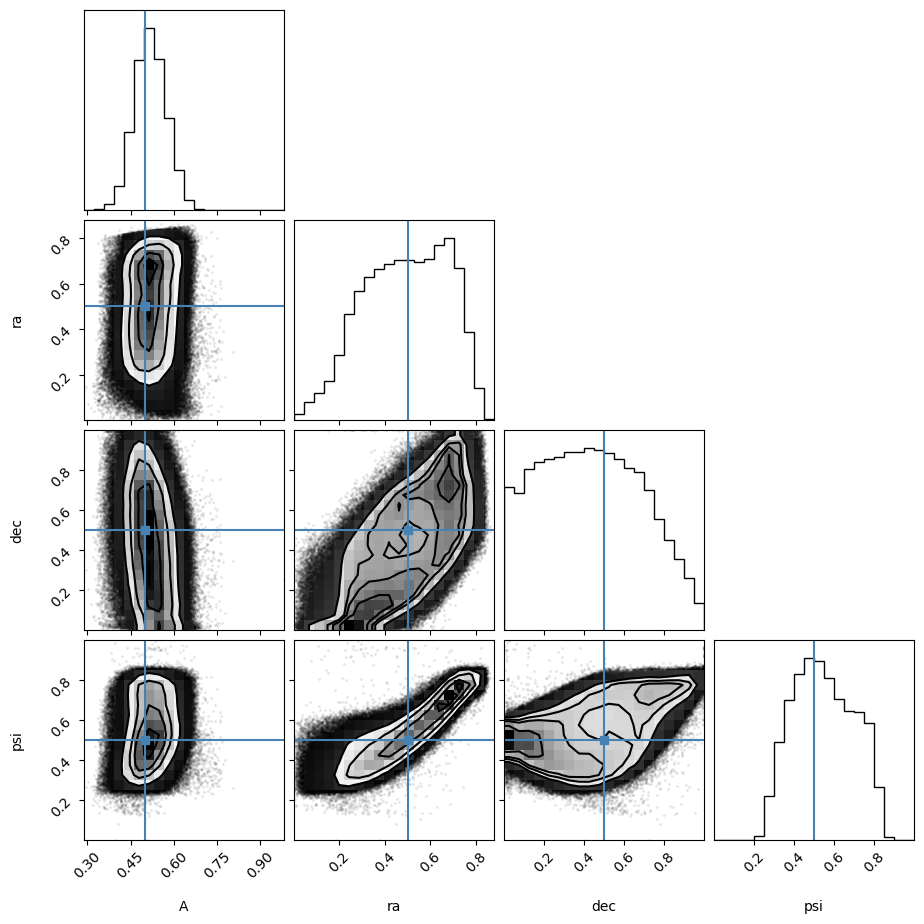

In [56]:
x_gen, log_prob_gen = sample_and_log_prob.apply(params, next(prng_seq), 500*Nsamps)
x_gen = np.array(x_gen, copy=False)
p_gen = np.vstack(list(log_l.array_to_phys(x_gen).values()))
fig = corner.corner(p_gen.T, labels=log_l.params, truths = truths)

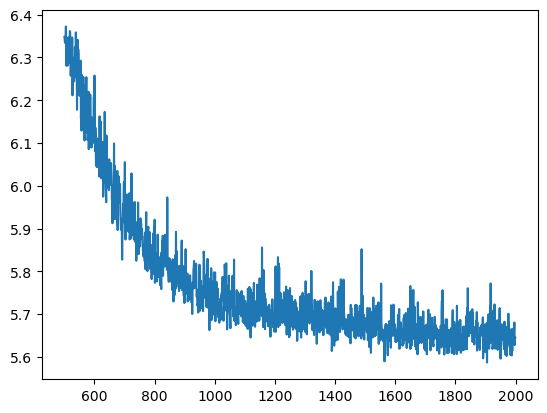

In [66]:
pl.plot(np.arange(500, 2000, 1), L[500:])

In [ ]:
from jax.test_util import check_grads
check_grads(loss_fn, params, order=2)  # check up to 2nd order derivatives

In [ ]:
jax.grad(logl)(true_params)

In [18]:
true_params = dict(A=0.5,t0=0.5,
        f0=20.,
        tau=1/10,
        ra=jnp.atleast_1d(0.5),
        dec=jnp.atleast_1d(0.5),
        psi=jnp.atleast_1d(0.5))

In [19]:
def logl(params):
    return log_l(params)[0]

In [20]:
def logl(x):
    p = dict()
    p['A'] = x[0]
    p['ra'] = jnp.atleast_1d(x[1])
    p['dec'] = jnp.atleast_1d(x[2]) 
    p['psi'] = jnp.atleast_1d(x[3]) 

    return log_l(p)[0]

In [21]:
def flatlogprior(theta,theta_min,theta_max):       # pass the parameter location and the parameter bounds
    if np.any(theta-theta_max>0) or np.any(theta_min-theta>0):
        return -np.inf     # if outside the bounds return probability = 0 (log-prob = -infinity)
    return 0.0             # otherwise just return logprob = 0.0

In [22]:
x = np.array([0.5,0.5,0.5,0.5])
x_min = np.array([0.,0.,0.,0.])
x_max = np.array([1.,1.,1.,1.])

In [26]:
def logprob(x, x_min, x_max):
    return logl(x)+flatlogprior(x, x_min, x_max)

In [31]:
import emcee

In [34]:
nwalkers = 32
ndim=4
p0 = np.random.rand(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, logprob, args=(x_min, x_max))

In [35]:
state = sampler.run_mcmc(p0, 100)
sampler.reset()

In [37]:
sampler.run_mcmc(state, 10000)

State([[0.62417362 0.34368148 0.1072396  0.42472098]
 [0.50013948 0.73737631 0.80846632 0.88180325]
 [0.58255824 0.50841844 0.19680857 0.54666937]
 [0.5842521  0.63838582 0.25563069 0.71602325]
 [0.59465161 0.81237488 0.52756062 0.84041837]
 [0.53313515 0.07366996 0.17092082 0.35246798]
 [0.46709282 0.73378545 0.91295216 0.77746471]
 [0.54320649 0.61560071 0.58215017 0.61402391]
 [0.48290607 0.49380193 0.32330881 0.50993036]
 [0.58523007 0.84477011 0.89873387 0.9428781 ]
 [0.49494264 0.44992972 0.33994638 0.51054641]
 [0.48491691 0.58141461 0.81685251 0.6270461 ]
 [0.5093522  0.50155371 0.21731246 0.53557243]
 [0.60243776 0.59191711 0.07953169 0.6166175 ]
 [0.42897373 0.67087337 0.82449919 0.81326122]
 [0.58472195 0.45492955 0.43574527 0.40013336]
 [0.52845091 0.52411287 0.71152033 0.53564435]
 [0.56132648 0.17040346 0.037373   0.43449099]
 [0.56107193 0.24071628 0.07473717 0.46876202]
 [0.50470175 0.23593742 0.54863559 0.30311471]
 [0.61589584 0.83167795 0.70806649 0.93655156]
 [0.481

In [61]:
#f = open('samples_vi.npy', 'wb')
#np.save(f,p_gen.T)
#f = open('samples.npy', 'rb')
#a = np.load(f)

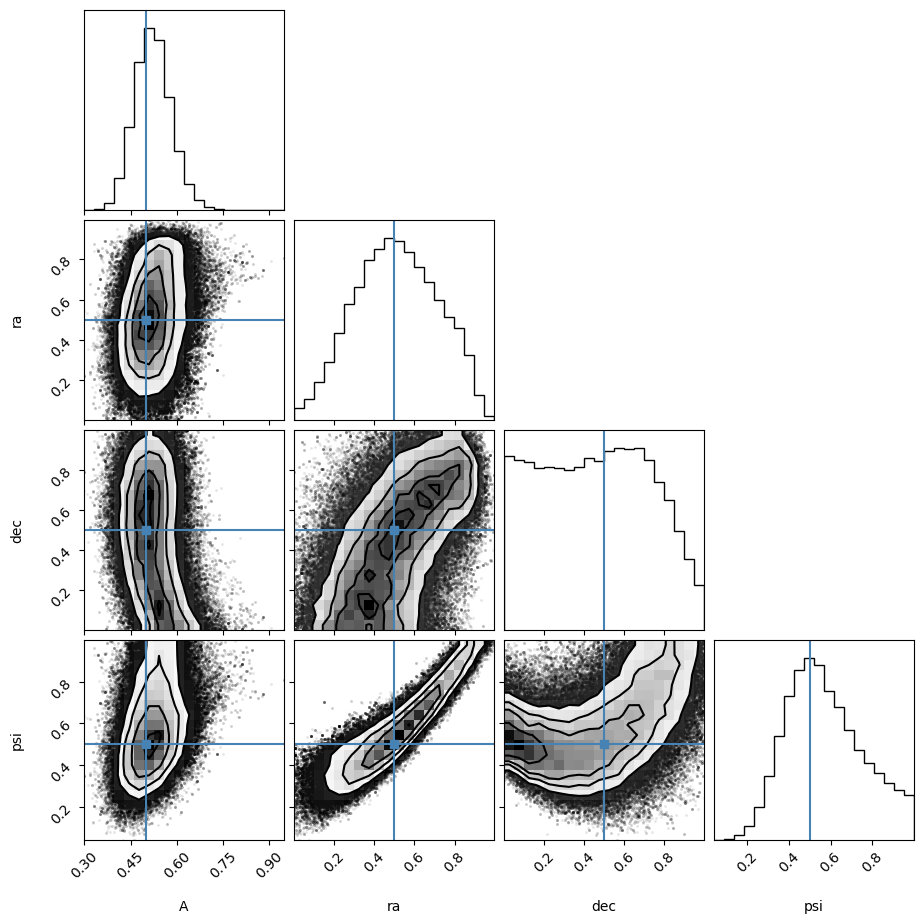

In [47]:
fig = corner.corner(samples, labels=log_l.params, truths = truths)
pl.show()

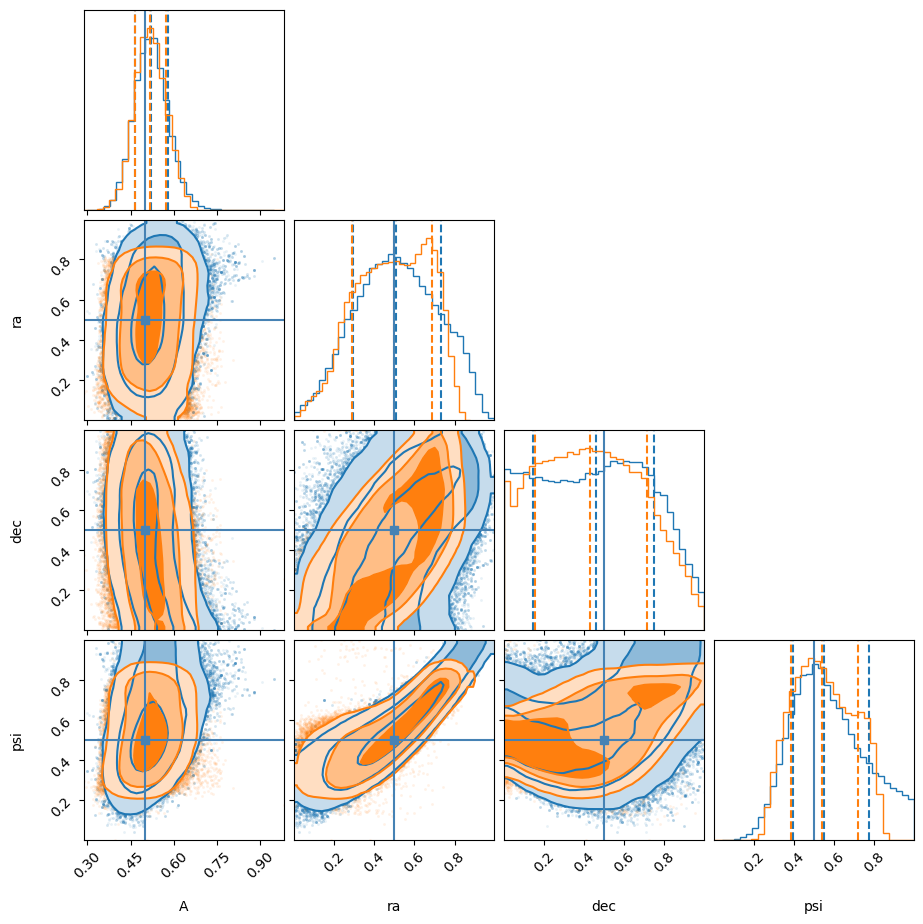

In [60]:

#n = 10_000
#dims = 2

#x1 = np.random.randn(n, dims) - 1
#x2 = np.random.randn(n, dims) + 1

kwargs = dict(
    bins=32,
    smooth=0.9,
    quantiles=[0.16, 0.5, 0.84],
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.0)),
    plot_density=True,
    plot_datapoints=True,
    fill_contours=True,
    show_titles=False,
    hist_kwargs=dict(density=True),
)

fig = None

# Need to update colours for 1D and 2D plots
kwargs["color"] = "C0"
kwargs["hist_kwargs"]["color"] = "C0"
fig = corner.corner(samples, fig=fig, **kwargs)

kwargs["color"] = "C1"
kwargs["hist_kwargs"]["color"] = "C1"
fig = corner.corner(p_gen.T, labels=log_l.params, truths = truths, fig=fig, **kwargs)

#fig.savefig("corner_comparison.png")
pl.show()